<a href="https://colab.research.google.com/github/sa96102/Python_exam/blob/master/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

### Prepare Model

In [0]:
proto = '/content/drive/My Drive/Colab Notebooks/Python_exam/Data/Image_colorization/colorization_deploy_v2.prototxt'
# 모델 아키텍처 파일
weights = '/content/drive/My Drive/Colab Notebooks/Python_exam/Data/Image_colorization/colorization_release_v2.caffemodel'
# 모델 weights 파일(일반 색채화 모델 사용.)
# weights = '/content/drive/My Drive/Colab Notebooks/Python_exam/Data/Image_colorization/colorization_release_v2_norebal.caffemodel'
# 모델 weights 파일(class rebalancing을 하지 않은 모델. 둔탁하기는 하지만 보다 안전한 색채화 모델임.)

# load cluster centers
pts_in_hull = np.load('/content/drive/My Drive/Colab Notebooks/Python_exam/Data/Image_colorization/pts_in_hull.npy')
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1).astype(np.float32)

# load model
net = cv2.dnn.readNetFromCaffe(proto, weights) # readNetFromCaffe()_Caffe 모델을 로드함.
# net.getLayerNames()

# populate cluster centers as 1x1 convolution kernel
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull] #cluster centers를 로드해서 convolution kernel에 넣는 과정.
# scale layer doesn't look work in OpenCV dnn module, we need to fill 2.606 to conv8_313_rh layer manually
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full((1, 313), 2.606, np.float32)] # 모든 weight를 2.606이라는 상수로 다 채움.

### Preprocessing

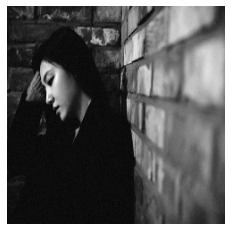

In [4]:
img_path = '/content/drive/My Drive/Colab Notebooks/Python_exam/Data/Image_colorization/sample.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # 이미지를 흑백으로 로드.
img_input = img.copy()

# convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # 흑백 이미지를 RGB 이미지로 변환.(채널만 3개로 늘어나고 컬러로 바뀌지는 않음.)

img_rgb = img.copy()

# normalize input
img_rgb = (img_rgb / 255.).astype(np.float32) # 255로 나누어 0~1 사이의 값을 가지도록 하고 이를 다시 float32형식으로 바꿈.

# convert RGB to LAB
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab) # RGB 이미지를 Lab 이미지로 변환.
# only L channel to be used
img_l = img_lab[:, :, 0] # 0번 채널(L)만 사용.

input_img = cv2.resize(img_l, (244, 244)) # cv2.resize(img, dsize)_이미지를 dsize 크기로 리사이즈. 모델 채널에 맞게 리사이즈.
input_img -= 50 # subtract 50 for mean-centering

plt.axis('off')
plt.imshow(input_img, cmap='gray')

### Prediction

True

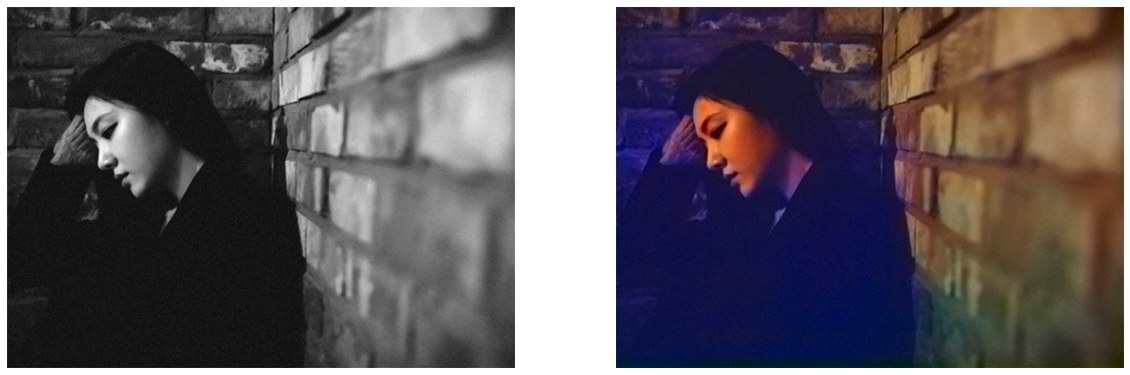

In [5]:
net.setInput(cv2.dnn.blobFromImage(input_img)) # net.setInput()_모델의 인풋 설정. cv2.dnn.blobFromImage(img)_이미지를 blob 데이터로 변환.
pred = net.forward()[0,:,:,:].transpose((1, 2, 0)) # net.forward()_이미지를 예측.(Inference)

# resize to original image shape
pred_resize = cv2.resize(pred, (img.shape[1], img.shape[0])) # 원본 크기 -> (244, 244) -> 예측 -> 원본크기 순으로.

# concatenate with original image L
pred_lab = np.concatenate([img_l[:, :, np.newaxis], pred_resize], axis=2) # np.concatenate()_Numpy 행렬을 붙임.
# output size가 2개의 채널이 나옴.(L채널을 넣으면 모델이 AB 채널을 예측하기 때문.) 그래서 이를 합치는 것이 np.concatenate.(LAB이미지를 만들기 위해.)

# convert LAB to RGB
pred_rgb = cv2.cvtColor(pred_lab, cv2.COLOR_Lab2RGB)
pred_rgb = np.clip(pred_rgb, 0, 1) * 255 # 이미지를 모델에 Input으로 넣을 때 255로 나누었으니 Out에서는 곱해줌.
pred_rgb = pred_rgb.astype(np.uint8) # OpenCV에서 표현할 수 있게 8비트 int로 변환.

# plot prediction result
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1).axis('off')
plt.imshow(img_l, cmap='gray')
fig.add_subplot(1, 2, 2).axis('off')
plt.imshow(pred_rgb)

# save result image file
filename, ext = os.path.splitext(img_path)
input_filename = '%s_input%s' % (filename, ext)
output_filename = '%s_output%s' % (filename, ext)

pred_rgb_output = cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2BGR)

cv2.imwrite(input_filename, img_input)
cv2.imwrite(output_filename, np.concatenate([img, pred_rgb_output], axis=1))